# Core

## Setup

In [ ]:
#| default_exp data.core

In [ ]:
#| export
# basics
import requests, subprocess,shutil,zipfile
import pandas as pd, numpy as np
from functools import lru_cache
from pathlib import Path
from fastcore.meta import delegates
# from tqdm import tqdm
# tqdm.pandas()
from tqdm.contrib.concurrent import process_map
pd.set_option('mode.chained_assignment', 'raise') # raise error when overwriting

# rdkit
from rdkit import Chem,DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw,Descriptors,Descriptors3D, AllChem,rdFingerprintGenerator

from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(transform_output="pandas")


## Uniprot sequence

In [ ]:
#| export
@lru_cache()
def get_uniprot_seq(uniprot_id):
    "Queries the UniProt database to retrieve the protein sequence for a given UniProt ID."
    
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        data = response.text
        # The sequence starts after the first line, which is a description
        sequence = ''.join(data.split('\n')[1:]).strip()
        return sequence
    else:
        return f"Error: Unable to retrieve sequence for UniProt ID {uniprot_id}. Status code: {response.status_code}"

In [ ]:
get_uniprot_seq('P04626')

'MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQVRQVPLQRLRIVRGTQLFEDNYALAVLDNGDPLNNTTPVTGASPGGLRELQLRSLTEILKGGVLIQRNPQLCYQDTILWKDIFHKNNQLALTLIDTNRSRACHPCSPMCKGSRCWGESSEDCQSLTRTVCAGGCARCKGPLPTDCCHEQCAAGCTGPKHSDCLACLHFNHSGICELHCPALVTYNTDTFESMPNPEGRYTFGASCVTACPYNYLSTDVGSCTLVCPLHNQEVTAEDGTQRCEKCSKPCARVCYGLGMEHLREVRAVTSANIQEFAGCKKIFGSLAFLPESFDGDPASNTAPLQPEQLQVFETLEEITGYLYISAWPDSLPDLSVFQNLQVIRGRILHNGAYSLTLQGLGISWLGLRSLRELGSGLALIHHNTHLCFVHTVPWDQLFRNPHQALLHTANRPEDECVGEGLACHQLCARGHCWGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYVNARHCLPCHPECQPQNGSVTCFGPEADQCVACAHYKDPPFCVARCPSGVKPDLSYMPIWKFPDEEGACQPCPINCTHSCVDLDDKGCPAEQRASPLTSIISAVVGILLVVVLGVVFGILIKRRQQKIRKYTMRRLLQETELVEPLTPSGAMPNQAQMRILKETELRKVKVLGSGAFGTVYKGIWIPDGENVKIPVAIKVLRENTSPKANKEILDEAYVMAGVGSPYVSRLLGICLTSTVQLVTQLMPYGCLLDHVRENRGRLGSQDLLNWCMQIAKGMSYLEDVRLVHRDLAARNVLVKSPNHVKITDFGLARLLDIDETEYHADGGKVPIKWMALESILRRRFTHQSDVWSYGVTVWELMTFGAKPYDGIPAREIPDLLEKGERLPQPPICTIDVYMIMVKCWMIDSECRPRFRELVSEFSRMARDPQRFVVIQNEDLGPASP

In [ ]:
#| export
@lru_cache()
def get_uniprot_features(uniprot_id):
    "Given uniprot_id, get specific region for uniprot features."
    # uniprot REST API
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Extract the "features" section which contains information
        features = data.get('features', [])
        return features
    else:
        raise ValueError(f"Failed to retrieve UniProt features for {uniprot_id}")

In [ ]:
get_uniprot_features('P04626')[:3]

[{'type': 'Signal',
  'location': {'start': {'value': 1, 'modifier': 'EXACT'},
   'end': {'value': 22, 'modifier': 'EXACT'}},
  'description': '',
  'evidences': [{'evidenceCode': 'ECO:0000255'}]},
 {'type': 'Chain',
  'location': {'start': {'value': 23, 'modifier': 'EXACT'},
   'end': {'value': 1255, 'modifier': 'EXACT'}},
  'description': 'Receptor tyrosine-protein kinase erbB-2',
  'featureId': 'PRO_0000016669'},
 {'type': 'Topological domain',
  'location': {'start': {'value': 23, 'modifier': 'EXACT'},
   'end': {'value': 652, 'modifier': 'EXACT'}},
  'description': 'Extracellular',
  'evidences': [{'evidenceCode': 'ECO:0000255'}]}]

In [ ]:
#| export
def get_uniprot_kd(uniprot_id):
    "Get kinase domain sequences based on UniProt ID."
    features = get_uniprot_features(uniprot_id)
    out_regions = []
    seq = get_uniprot_seq(uniprot_id)

    for feature in features:
        if feature.get("type") == "Domain" and "Protein kinase" in feature.get("description", ""):
            start = feature['location']['start']['value']
            end = feature['location']['end']['value']
            region = {
                'uniprot_id': uniprot_id,
                'type': feature['type'],
                'start': start,
                'end': end,
                'description': feature['description'],
                'sequence': seq[start-1:end]
            }
            out_regions.append(region)

    return out_regions

In [ ]:
get_uniprot_kd('P04626')

[{'uniprot_id': 'P04626',
  'type': 'Domain',
  'start': 720,
  'end': 987,
  'description': 'Protein kinase',
  'sequence': 'LRKVKVLGSGAFGTVYKGIWIPDGENVKIPVAIKVLRENTSPKANKEILDEAYVMAGVGSPYVSRLLGICLTSTVQLVTQLMPYGCLLDHVRENRGRLGSQDLLNWCMQIAKGMSYLEDVRLVHRDLAARNVLVKSPNHVKITDFGLARLLDIDETEYHADGGKVPIKWMALESILRRRFTHQSDVWSYGVTVWELMTFGAKPYDGIPAREIPDLLEKGERLPQPPICTIDVYMIMVKCWMIDSECRPRFRELVSEFSRMARDPQRFV'}]

In [ ]:
#| export
def get_uniprot_type(uniprot_id,type_='Signal'):
    "Get region sequences based on UniProt ID features."
    features = get_uniprot_features(uniprot_id)
    out_regions = []
    seq = get_uniprot_seq(uniprot_id)

    for feature in features:
        if feature.get("type") == type_:
            start = feature['location']['start']['value']
            end = feature['location']['end']['value']
            region = {
                'uniprot_id': uniprot_id,
                'type': feature['type'],
                'start': start,
                'end': end,
                'description': feature['description'],
                'sequence': seq[start-1:end]
            }
            out_regions.append(region)

    return out_regions

In [ ]:
get_uniprot_type('P04626','Signal') # signal peptide

[{'uniprot_id': 'P04626',
  'type': 'Signal',
  'start': 1,
  'end': 22,
  'description': '',
  'sequence': 'MELAALCRWGLLLALLPPGAAS'}]

In [ ]:
get_uniprot_type('P04626','Transmembrane') # tm domain

[{'uniprot_id': 'P04626',
  'type': 'Transmembrane',
  'start': 653,
  'end': 675,
  'description': 'Helical',
  'sequence': 'SIISAVVGILLVVVLGVVFGILI'}]

## Mutate sequence

In [ ]:
#| export
def mutate(seq, # protein sequence
           *mutations, # e.g., E709A
           verbose=True,
           ):
    "Apply mutations to a protein sequence."
    seq_list = list(seq)  # convert to list for mutability
    
    for mut in mutations:
        # check mutation format
        if len(mut) < 3: raise ValueError(f"Invalid mutation format: {mut}")
        
        from_aa,pos,to_aa = mut[0],int(mut[1:-1])-1,mut[-1]

        # make sure position is within the sequence length
        if pos < 0 or pos >= len(seq_list): raise IndexError(f"Position {pos + 1} out of range for sequence length {len(seq_list)}")
        # make sure aa from mutations matches the residue on the sequence
        if seq_list[pos] != from_aa: raise ValueError(f"Expected {from_aa} at position {pos + 1}, found {seq_list[pos]}")
        
        seq_list[pos] = to_aa
        if verbose: print('Converted:', mut)
        
    return ''.join(seq_list)

In [ ]:
seq = get_uniprot_seq('P04626')
mut_seq = mutate(seq,'M1A','E2S')
mut_seq

Converted: M1A
Converted: E2S


'ASLAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQVRQVPLQRLRIVRGTQLFEDNYALAVLDNGDPLNNTTPVTGASPGGLRELQLRSLTEILKGGVLIQRNPQLCYQDTILWKDIFHKNNQLALTLIDTNRSRACHPCSPMCKGSRCWGESSEDCQSLTRTVCAGGCARCKGPLPTDCCHEQCAAGCTGPKHSDCLACLHFNHSGICELHCPALVTYNTDTFESMPNPEGRYTFGASCVTACPYNYLSTDVGSCTLVCPLHNQEVTAEDGTQRCEKCSKPCARVCYGLGMEHLREVRAVTSANIQEFAGCKKIFGSLAFLPESFDGDPASNTAPLQPEQLQVFETLEEITGYLYISAWPDSLPDLSVFQNLQVIRGRILHNGAYSLTLQGLGISWLGLRSLRELGSGLALIHHNTHLCFVHTVPWDQLFRNPHQALLHTANRPEDECVGEGLACHQLCARGHCWGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYVNARHCLPCHPECQPQNGSVTCFGPEADQCVACAHYKDPPFCVARCPSGVKPDLSYMPIWKFPDEEGACQPCPINCTHSCVDLDDKGCPAEQRASPLTSIISAVVGILLVVVLGVVFGILIKRRQQKIRKYTMRRLLQETELVEPLTPSGAMPNQAQMRILKETELRKVKVLGSGAFGTVYKGIWIPDGENVKIPVAIKVLRENTSPKANKEILDEAYVMAGVGSPYVSRLLGICLTSTVQLVTQLMPYGCLLDHVRENRGRLGSQDLLNWCMQIAKGMSYLEDVRLVHRDLAARNVLVKSPNHVKITDFGLARLLDIDETEYHADGGKVPIKWMALESILRRRFTHQSDVWSYGVTVWELMTFGAKPYDGIPAREIPDLLEKGERLPQPPICTIDVYMIMVKCWMIDSECRPRFRELVSEFSRMARDPQRFVVIQNEDLGPASP

In [ ]:
#| export
def compare_seq(original_seq, mutated_seq):
    "Compare original and mutated sequences."
    
    if len(original_seq) != len(mutated_seq): raise ValueError("Sequences must be the same length to compare.")

    differences = []
    for i, (orig, mut) in enumerate(zip(original_seq, mutated_seq), start=1):
        if orig != mut:
            differences.append((i, orig, mut))

    if not differences: print("No differences found. Sequences are identical.")
    else:
        print("Differences found at positions:")
        for pos, orig, mut in differences:
            print(f"  Position {pos}: {orig} → {mut}")

In [ ]:
compare_seq(seq,mut_seq)

Differences found at positions:
  Position 1: M → A
  Position 2: E → S


## Compound Datahub

In [ ]:
#| export
class Data:
    "A class for fetching various datasets."

    ANTIBIOTICS_URL = "https://github.com/sky1ove/kdock/raw/main/dataset/antibiotics_2335.csv"
    G12D_URL = "https://github.com/sky1ove/kdock/raw/main/dataset/KRASi_g12d.csv"
    G12D_DEDUP_URL = "https://github.com/sky1ove/kdock/raw/main/dataset/KRASi_g12d_dedup.csv"
    KRAS_SEQ_URL = "https://github.com/sky1ove/kdock/raw/main/dataset/kras_seq.csv"

    @staticmethod
    @lru_cache(maxsize=None)
    def fetch_csv(url): return pd.read_csv(url)
    
    @staticmethod
    def get_antibiotics():
        "Deduplicated screening antibiotics dataset; Table S1B from Cell: A Deep Learning Approach to Antibiotic Discovery."
        return Data.fetch_csv(Data.ANTIBIOTICS_URL)
    
    @staticmethod
    def get_mirati_g12d():
        "Get the deduplicated G12D dataset from the mirati paper and patents."
        return Data.fetch_csv(Data.G12D_DEDUP_URL)
    
    @staticmethod
    def get_mirati_g12d_raw():
        "Get the raw combined G12D dataset from the paper and patents."
        return Data.fetch_csv(Data.G12D_URL)
    
    @staticmethod
    def get_kras_seq():
        "Get the sequence of KRAS and its mutations G12D and G12C."
        return Data.fetch_csv(Data.KRAS_SEQ_URL)

In [ ]:
Data.get_antibiotics().head()

,name,SMILES,inhibition,activity
0,CEFPIRAMIDE,Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(C...,0.041572,1
1,GEMIFLOXACIN MESYLATE,CON=C1CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC...,0.041876,1
2,POLYMYXIN B SULFATE,CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O...,0.041916,1
3,PRAXADINE HYDROCHLORIDE,Cl.N=C(N)n1cccn1,0.041964,1
4,CHLORHEXIDINE DIHYDROCHLORIDE,Cl.Cl.N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(...,0.042295,1


In [ ]:
Data.get_mirati_g12d().head()

,ID,SMILES,Kd,IC50,erk_IC50
0,US_1,CN1CCC[C@H]1COc1nc(N2CC3CCC(C2)N3)c2cnc(cc2n1)...,97.7,124.7,3159.1
1,US_4,Oc1cc(-c2ncc3c(nc(OCCc4ccccn4)nc3c2F)N2CC3CCC(...,155.7,496.2,8530.0
2,US_5,Cn1nccc1COc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)-...,294.8,722.9,8193.8
3,US_6,Cc1cccnc1CCOc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1...,442.2,434.1,11518.2
4,US_7,Oc1cc(-c2ncc3c(nc(OCCc4ncccn4)nc3c2F)N2CC3CCC(...,463.5,1867.3,NaN


In [ ]:
Data.get_mirati_g12d_raw().head()

,ID,SMILES,group,with_3F,racemic_trans,mixture_isomer,trans,Kd,IC50,erk_IC50
0,US_1,CN1CCC[C@H]1COc1nc(N2CC3CCC(C2)N3)c2cnc(cc2n1)...,US,0,0,0,0,97.7,124.7,3159.1
1,US_2,CN1CCC[C@H]1COc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2...,US,1,0,0,0,2.4,2.7,721.4
2,US_3,Cn1ccnc1CCOc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)...,US,0,0,0,0,8.3,9.5,10283.1
3,US_4,Oc1cc(-c2ncc3c(nc(OCCc4ccccn4)nc3c2F)N2CC3CCC(...,US,0,0,0,0,155.7,496.2,8530.0
4,US_5,Cn1nccc1COc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)-...,US,0,0,0,0,294.8,722.9,8193.8


In [ ]:
Data.get_kras_seq().head()

,ID,WT_sequence,g12d_seq,g12c_seq
0,kras_human,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,MTEYKLVVVGACGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
1,kras_human_isoform2b,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,MTEYKLVVVGACGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...


## Copy files

Using `list(Path('files').rglob('*.pdb'))` will get all the pdb files of subfolders. Here we define a function that can limit the depth of search.

In [ ]:
#| export
def rglob(path, pattern, max_depth):
    "Get a file list given folder depths"
    base_path = Path(path).resolve()
    for path in base_path.rglob(pattern):
        if len(path.relative_to(base_path).parts) <= max_depth:
            yield path

In [ ]:
file_list = list(rglob('files','*.pdb',1))
file_list

[PosixPath('/teamspace/studios/this_studio/kdock/nbs/data/files/7OFF_lig.pdb'),
 PosixPath('/teamspace/studios/this_studio/kdock/nbs/data/files/7OFF_receptor.pdb'),
 PosixPath('/teamspace/studios/this_studio/kdock/nbs/data/files/7OFF.pdb')]

In [ ]:
#| export
def copy_files(file_list, dest_dir):
    "Copy a list of files to the destination directory, or zip them if dest_dir ends with .zip."
    dest_path = Path(dest_dir)

    if dest_path.suffix == ".zip":
        with zipfile.ZipFile(dest_path, 'w') as zipf:
            for file_path in file_list:
                file_path = Path(file_path)
                zipf.write(file_path, arcname=file_path.name)
        print(f'Zipped {len(file_list)} files to {dest_path}')
    else:
        dest_path.mkdir(parents=True, exist_ok=True)
        for file_path in file_list:
            file_path = Path(file_path)
            shutil.copy2(file_path, dest_path / file_path.name)
        print(f'Copied {len(file_list)} files to {dest_path}')

In [ ]:
copy_files(file_list,'files/protein.zip') # support zip
copy_files(file_list,'files/protein')

Zipped 3 files to files/protein.zip
Copied 3 files to files/protein


## Conformer

In [ ]:
#| export
def rdkit_conformer(SMILES, # SMILES string
                    output=None, # file ".sdf" to be saved
                    method='ETKDG', # Optimization method, can be 'UFF', 'MMFF' or 'ETKDGv3'
                    visualize=True, #whether or not to visualize the compound
                    seed = 3,# randomness of the 3D conformation
                    ):

    "Gemerate 3D conformers from SMILES"
    
    np.random.seed(seed) 
    mol = Chem.MolFromSmiles(SMILES)
    
    # Generate a 3D conformation of the molecule
    AllChem.EmbedMolecule(mol)
    

    # Optimize the 3D conformation using the specified force field method
    if method == 'UFF':
        AllChem.UFFOptimizeMolecule(mol)
    elif method == 'MMFF':
        AllChem.MMFFOptimizeMolecule(mol)
    elif method == 'ETKDG':
        AllChem.EmbedMultipleConfs(mol, numConfs=1, useExpTorsionAnglePrefs=True, 
                                   useBasicKnowledge=True, enforceChirality=True,randomSeed=seed)
        AllChem.ETKDGv3()
        AllChem.UFFOptimizeMolecule(mol)

    else:
        raise ValueError('Invalid method specified')
        

    # Remove hydrogens from the molecule
    # mol = Chem.RemoveHs(mol)

    if output is not None:
        Path(output).parent.mkdir(parents=True,exist_ok=True)
    
        w = Chem.SDWriter(output)
        w.write(mol)
        w.close()
    return mol

[01:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[01:17:18] Molecule does not have explicit Hs. Consider calling AddHs()
[01:17:18] Molecule does not have explicit Hs. Consider calling AddHs()


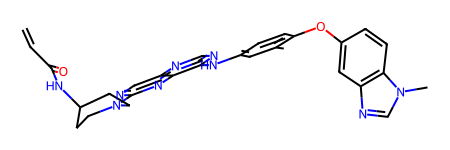

In [ ]:
rdkit_conformer('CC1=C(C=CC(=C1)NC2=NC=NC3=CN=C(N=C32)N4CCC(CC4)NC(=O)C=C)OC5=CC6=C(C=C5)N(C=N6)C')

## Get receptor and ligand from pdb

In [ ]:
#| export
def get_rec_lig(pdb_id: str, # pdb id for download
                            lig_id: str, # ligand id shown on the protein page
                            out_dir = '.', # directory path to save pdb files
                            ):
    "Download pdb and extract receptor and ligand from a PDB ID."
    out_dir = Path(out_dir).expanduser().resolve()
    out_dir.mkdir(parents=True, exist_ok=True)

    pdb_file = out_dir / f"{pdb_id}.pdb"
    rec_file = out_dir / f"{pdb_id}_receptor.pdb"
    lig_pdb_file = out_dir / f"{pdb_id}_lig.pdb"
    lig_sdf_file = out_dir / f"{pdb_id}_lig.sdf"

    # Download if not exists
    if not pdb_file.exists():
        url = f"http://files.rcsb.org/download/{pdb_id}.pdb"
        print(f'Downloading pdb: {pdb_id}')
        subprocess.run(["wget", url, "-O", str(pdb_file)], check=True,stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print(f'{pdb_id}.pdb is detected!')

    # Extract protein (all ATOM lines excluding ligand ID)
    with open(pdb_file) as infile, open(rec_file, 'w') as out_rec:
        for line in infile:
            if line.startswith("ATOM") and lig_id not in line:
                out_rec.write(line)

    # Extract ligand
    with open(pdb_file) as infile, open(lig_pdb_file, 'w') as out_lig:
        for line in infile:
            if lig_id in line and line.startswith(("HETATM", "ATOM")):
                out_lig.write(line)

    # Convert ligand PDB to SDF using RDKit
    mol = Chem.MolFromPDBFile(str(lig_pdb_file), removeHs=False)
    if mol is None:
        raise ValueError("Failed to parse ligand from PDB.")
    
    writer = Chem.SDWriter(str(lig_sdf_file))
    writer.write(mol)
    writer.close()

    return str(rec_file), str(lig_sdf_file)

In [ ]:
rec_path,lig_path = get_rec_lig('7OFF','VCB','files')
rec_path,lig_path

7OFF.pdb is detected!


('/teamspace/studios/this_studio/kdock/nbs/data/files/7OFF_receptor.pdb',
 '/teamspace/studios/this_studio/kdock/nbs/data/files/7OFF_lig.sdf')

## Get ligand box

In [ ]:
#| export
def get_box(sdf_file, autobox_add=4.0,tolist=False):
    "Get the box coordinates of ligand.sdf; mimic GNINA's --autobox_ligand behavior."
    mol = Chem.SDMolSupplier(str(sdf_file), removeHs=False)[0]
    if mol is None:
        raise ValueError(f"Failed to read molecule from {sdf_file}")
    
    conf = mol.GetConformer()
    coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])
    
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    
    center = (min_coords + max_coords) / 2
    size = (max_coords - min_coords) + autobox_add

    box_dict = {
        "center_x": round(float(center[0]), 3),
        "center_y": round(float(center[1]), 3),
        "center_z": round(float(center[2]), 3),
        "size_x": round(float(size[0]), 3),
        "size_y": round(float(size[1]), 3),
        "size_z": round(float(size[2]), 3)
    }
    return list(box_dict.values()) if tolist else box_dict

In [ ]:
box = get_box(lig_path)
box

{'center_x': 38.848,
 'center_y': -26.77,
 'center_z': 10.419,
 'size_x': 14.652,
 'size_y': 8.942,
 'size_z': 12.509}

In [ ]:
box_list = get_box(lig_path,tolist=True)
box_list

[38.848, -26.77, 10.419, 14.652, 8.942, 12.509]

In [ ]:
#| export
def tanimoto(df, # df with SMILES and ID columns
             smiles_col='SMILES', # colname of SMILES
             id_col='ID', # colname of compound ID
             target_col=None, # colname of compound values (e.g., IC50)
             radius=2, # radius of the Morgan fingerprint.
             ):
    "Calculates the Tanimoto similarity scores between all pairs of molecules in a pandas DataFrame."
    
    df = df.copy()
    # Convert SMILES to molecule objects
    df['Molecule'] = df[smiles_col].apply(lambda x: Chem.MolFromSmiles(x))

    # Calculate fingerprints
    df['Fingerprint'] = df['Molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius))

    # Calculate similarity scores
    similarity_scores = []
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            sim_score = DataStructs.TanimotoSimilarity(df['Fingerprint'][i], df['Fingerprint'][j])
            if target_col is not None:
                similarity_scores.append((df[id_col][i], df[id_col][j], df[smiles_col][i], df[smiles_col][j], sim_score, df[target_col][i], df[target_col][j]))
            else:
                similarity_scores.append((df[id_col][i], df[id_col][j], df[smiles_col][i], df[smiles_col][j], sim_score))

    # Create a new DataFrame with the similarity scores
    if target_col is not None:
        result_df = pd.DataFrame(similarity_scores, columns=['ID1', 'ID2', 'SMILES1', 'SMILES2', 'SimilarityScore', 'Target1', 'Target2'])
    else:
        result_df = pd.DataFrame(similarity_scores, columns=['ID1', 'ID2', 'SMILES1', 'SMILES2', 'SimilarityScore'])

    # Sort by similarity score in descending order
    result_df.sort_values('SimilarityScore', ascending=False, inplace=True)
    result_df = result_df.reset_index(drop=True)

    return result_df

In [ ]:
df = Data.get_mirati_g12d_raw()[['ID','SMILES','IC50']]
df = df.dropna(subset= 'IC50').reset_index(drop=True)

In [ ]:
df.head()

,ID,SMILES,IC50
0,US_1,CN1CCC[C@H]1COc1nc(N2CC3CCC(C2)N3)c2cnc(cc2n1)...,124.7
1,US_2,CN1CCC[C@H]1COc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2...,2.7
2,US_3,Cn1ccnc1CCOc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)...,9.5
3,US_4,Oc1cc(-c2ncc3c(nc(OCCc4ccccn4)nc3c2F)N2CC3CCC(...,496.2
4,US_5,Cn1nccc1COc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)-...,722.9


In [ ]:
# result = tanimoto(df.head(), target_col = 'IC50')

TODO: modify morgan/ecfp

TODO: add more fingerprints

## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()